# Training Loop Testing Notebook
## Reasoning Distillation Project

This notebook tests:
1. Distillation loss computation
2. Trainer initialization
3. Training loop (small scale)
4. Evaluation pipeline
5. Checkpointing and resuming
6. Training history visualization

# ⚠️ DEFINITIVE TRAINING SETUP (NOT TESTING)

This notebook has been updated with **production-ready distillation training** configuration.

## Key Changes from Test Setup:
1. **Dataset Size**: 2000 training samples (↑ from 100)
2. **Distill Weight**: 0.6 (↑ from 0.0) - **DISTILLATION ACTIVATED!**
3. **Training Epochs**: 10 epochs (↑ from 2)
4. **Batch Size**: 32 (↑ from 8)
5. **Warmup Steps**: 500 (↑ from 10)
6. **Label Smoothing**: 0.0 (disabled, was causing issues)
7. **LR Scheduler**: Cosine annealing (better convergence)
8. **Gradient Accumulation**: 2 steps (improved stability)
9. **Evaluation**: Every 200 steps (was 10)

This is now a **real distillation training** where the model learns from both supervised data (40%) and explanations/teacher patterns (60%).

In [1]:
# Setup
import sys
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Add project root to path
project_root = Path.cwd().parent
sys.path.insert(0, str(project_root))

# Imports
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pprint import pprint
import time

from src.data.data_loader import TeacherDataLoader
from src.data.preprocessor import ReasoningPreprocessor, PreprocessConfig
from src.data.dataset import ESNLIDataset, create_dataloaders

from src.models.student import StudentModel, StudentConfig, create_student_model
from src.models.teacher import DatasetTeacher

from src.training.distillation import (
    DistillationConfig,
    SequenceLevelDistillation,
    DistillationLoss,
    compare_distillation_strategies
)

from src.training.trainer import (
    Trainer,
    TrainingConfig,
    create_trainer
)

In [2]:
# Set device (GPU or CPU)
# This determines where models and tensors will be loaded during training
device = "cuda" if torch.cuda.is_available() else "cpu"

## 1. Compare Distillation Strategies

In [3]:
# Display strategy comparison
compare_distillation_strategies()

DISTILLATION STRATEGIES

1. Sequence-Level Distillation (RECOMMENDED)
   ✓ Uses dataset as implicit teacher
   ✓ No teacher model needed during training
   ✓ Efficient and scalable
   ✓ Focus on final predictions and explanations
   ✗ Doesn't capture intermediate reasoning

2. Token-Level Distillation
   ✓ Learns from soft probability distributions
   ✓ Can capture richer knowledge
   ✗ Requires teacher model during training
   ✗ Much slower and memory intensive
   ✗ Overkill for explanation generation

3. Multi-Task Distillation
   ✓ Handles multiple datasets/tasks
   ✓ Task-specific loss weighting
   ✓ Good for combining multiple NLI datasets
   ✗ Requires careful weight tuning

4. Curriculum Distillation
   ✓ Gradually increases difficulty
   ✓ Can improve convergence
   ✓ Useful for complex reasoning
   ✗ Adds hyperparameter complexity


## 3. Prepare Dataset for Testing

In [ ]:
# Load dataset for definitive training
print("=" * 70)
print("LOADING DATASET FOR DEFINITIVE TRAINING")
print("=" * 70)

loader = TeacherDataLoader()
esnli_data = loader.load_esnli()

# Use larger subsets for proper training
train_subset = esnli_data['train'].select(range(2000))  # 2000 samples for proper training
val_subset = esnli_data['validation'].select(range(500))  # 500 validation samples

print(f"\n✓ Train samples: {len(train_subset)}")
print(f"✓ Val samples: {len(val_subset)}")

INFO:src.data.data_loader:Loading e-SNLI dataset from GitHub (OanaMariaCamburu/e-SNLI)...


LOADING TEST DATA


INFO:src.data.data_loader:✓ Loaded e-SNLI: train=549367, val=9842, test=9824
INFO:src.data.data_loader:e-SNLI loaded successfully. Splits: ['train', 'validation', 'test']
INFO:src.data.data_loader:Sample counts: [('train', 549367), ('validation', 9842), ('test', 9824)]



✓ Train samples: 100
✓ Val samples: 30


In [ ]:
# Create datasets and dataloaders
preprocess_config = PreprocessConfig(
    model_name="google/flan-t5-small",  # Use small for faster testing
    max_source_length=128,
    max_target_length=64
)

# Initialize preprocessor
preprocessor = ReasoningPreprocessor(preprocess_config)

# Create datasets
train_dataset = ESNLIDataset(train_subset, preprocessor, use_cache=True)
val_dataset = ESNLIDataset(val_subset, preprocessor, use_cache=True)

# Create dataloaders with proper batch size
train_loader, val_loader = create_dataloaders(
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    batch_size=32, # batch size for proper training (increased from 8)
    num_workers=4, # use parallel workers for faster loading
    pad_token_id=preprocessor.tokenizer.pad_token_id # pad token ID from tokenizer
)

print(f"\nTrain batches: {len(train_loader)}")
print(f"Val batches: {len(val_loader)}")

INFO:src.data.preprocessor:Loading tokenizer: google/flan-t5-small
INFO:src.data.dataset:Initialized ESNLIDataset with 100 samples
INFO:src.data.dataset:Initialized ESNLIDataset with 30 samples



Train batches: 13
Val batches: 4


## 4. Initialize Student Model

In [6]:
# Create small student model for fast testing
print("=" * 70)
print("INITIALIZING STUDENT MODEL")
print("=" * 70)

student_config = StudentConfig(
    model_name="google/flan-t5-small",
    max_source_length=128,
    max_target_length=64,
    device=device
)

student = StudentModel(student_config)

print(f"\nModel loaded: {student.count_parameters():,} parameters")
print(f"Memory: {student.get_memory_footprint()['total_mb']:.2f} MB")

INFO:src.models.student:Initializing student model: google/flan-t5-small


INITIALIZING STUDENT MODEL


The following generation flags are not valid and may be ignored: ['top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
INFO:src.models.student:Model loaded successfully on cuda
INFO:src.models.student:Model parameters: 76,961,152



Model loaded: 76,961,152 parameters
Memory: 293.58 MB


## 5. Initialize Distillation Strategy

In [ ]:
# Create sequence-level distillation strategy
print("=" * 70)
print("INITIALIZING DISTILLATION STRATEGY")
print("=" * 70)

distill_config = DistillationConfig(
    ce_weight=0.4,  # Cross-entropy weight (40% supervised learning)
    distill_weight=0.6,  # Distillation weight (60% from explanations/teacher) - ACTIVATED FOR DEFINITIVE TRAINING
    label_smoothing=0.0,  # Disable label smoothing (was causing issues)
    temperature=2.0, # Temperature for softening
    distillation_type="sequence_level" # Sequence-level distillation
)

distillation_strategy = SequenceLevelDistillation(distill_config)

print("\nSequenceLevelDistillation initialized!")

INFO:src.training.distillation:Initialized DistillationLoss with config:
INFO:src.training.distillation:  CE weight: 1.0
INFO:src.training.distillation:  Distill weight: 0.0
INFO:src.training.distillation:  Temperature: 2.0
INFO:src.training.distillation:  Type: sequence_level
INFO:src.training.distillation:Initialized SequenceLevelDistillation


INITIALIZING DISTILLATION STRATEGY

SequenceLevelDistillation initialized!


## 6. Test Single Training Step

In [8]:
# Test single training step manually
print("=" * 70)
print("TESTING SINGLE TRAINING STEP")
print("=" * 70)

# Get a batch
batch = next(iter(train_loader))
batch = {k: v.to(device) for k, v in batch.items()}

print(f"\nBatch shapes:")
for key, value in batch.items():
    print(f"  {key}: {value.shape}")

# Forward pass
student.model.train()
outputs = student(
    input_ids=batch['input_ids'],
    attention_mask=batch['attention_mask'],
    labels=batch['labels']
)

# Compute distillation loss
losses = distillation_strategy.compute_loss(
    outputs['logits'],
    batch['labels']
)

print(f"\nLoss values:")
for key, value in losses.items():
    print(f"  {key}: {value.item():.4f}")

# Backward pass
loss = losses['total_loss']
loss.backward()

print("\n✓ Forward and backward pass successful!")

# Check gradients
grad_norm = torch.nn.utils.clip_grad_norm_(student.model.parameters(), 1.0)
print(f"✓ Gradient norm: {grad_norm:.4f}")

TESTING SINGLE TRAINING STEP

Batch shapes:
  input_ids: torch.Size([8, 128])
  attention_mask: torch.Size([8, 128])
  labels: torch.Size([8, 64])

Loss values:
  ce_loss: 5.2803
  total_loss: 5.2803

✓ Forward and backward pass successful!
✓ Gradient norm: 12.9115


## 7. Initialize Trainer

In [ ]:
# Create training configuration
print("=" * 70)
print("INITIALIZING TRAINER")
print("=" * 70)

training_config = TrainingConfig(
    num_epochs=10,  # 10 epochs for proper training (increased from 2)
    learning_rate=5e-5,
    warmup_steps=500,  # Proper warmup (increased from 10)
    eval_steps=200,  # Evaluate every 200 steps
    save_steps=500,  # Save checkpoint every 500 steps
    logging_steps=50,  # Log every 50 steps
    output_dir="../experiments/distillation_run",  # Separate directory for definitive run
    eval_strategy="steps",
    save_strategy="steps",
    save_total_limit=3,  # Keep best 3 checkpoints
    early_stopping_patience=3,  # Stop if no improvement for 3 evaluations
    early_stopping_threshold=0.001,
    lr_scheduler_type="cosine",  # Use cosine annealing for better convergence
    gradient_accumulation_steps=2,  # Accumulate gradients (helps with stability)
    max_grad_norm=1.0,
    fp16=False,  # Can be enabled if on GPU with enough memory
    seed=42  # For reproducibility
)

# Re-initialize model (previous one has gradients)
student = StudentModel(student_config)

# Create trainer
trainer = Trainer(
    model=student,
    train_dataloader=train_loader,
    eval_dataloader=val_loader,
    distillation_strategy=distillation_strategy,
    config=training_config
)

print("\n✓ Trainer initialized!")
print(f"✓ Total training steps: {len(train_loader) * training_config.num_epochs}")

INFO:src.models.student:Initializing student model: google/flan-t5-small


INITIALIZING TRAINER


INFO:src.models.student:Model loaded successfully on cuda
INFO:src.models.student:Model parameters: 76,961,152
INFO:src.training.trainer:Training config saved to ../experiments/test_run/training_config.json
INFO:src.training.trainer:Trainer initialized
INFO:src.training.trainer:Output directory: ../experiments/test_run
INFO:src.training.trainer:Total training steps: 26



✓ Trainer initialized!
✓ Total training steps: 26


## 8. Run Training Loop

In [10]:
# Train the model
print("\n" + "=" * 70)
print("STARTING TRAINING")
print("=" * 70)

start_time = time.time()

history = trainer.train()

training_time = time.time() - start_time

print(f"\n✓ Training completed in {training_time:.2f}s")
print(f"✓ Average time per epoch: {training_time / training_config.num_epochs:.2f}s")

INFO:src.training.trainer:======================================================================
INFO:src.training.trainer:STARTING TRAINING
INFO:src.training.trainer:======================================================================
INFO:src.training.trainer:Epochs: 2
INFO:src.training.trainer:Train batches per epoch: 13
INFO:src.training.trainer:Eval batches: 4
INFO:src.training.trainer:
INFO:src.training.trainer:Epoch 1/2
INFO:src.training.trainer:======================================================================



STARTING TRAINING


Epoch 1:  62%|██████▏   | 8/13 [00:01<00:00,  8.39it/s, loss=4.8775, lr=5.00e-05]INFO:src.training.trainer:Step 10 | ce_loss: 4.8775 | total_loss: 4.8775 | LR: 5.00e-05
INFO:src.training.trainer:
Running evaluation...

Evaluating: 100%|██████████| 4/4 [00:00<00:00, 32.59it/s]
INFO:src.training.trainer:
Evaluation at step 10:
INFO:src.training.trainer:  eval_loss: 2.6282
INFO:src.training.trainer:Saving checkpoint to ../experiments/test_run/best_model
INFO:src.models.student:Saving model to ../experiments/test_run/best_model
INFO:src.models.student:Model saved successfully
Epoch 1: 100%|██████████| 13/13 [00:03<00:00,  4.13it/s, loss=4.6825, lr=4.06e-05]
INFO:src.training.trainer:
Epoch 1 metrics:
INFO:src.training.trainer:  loss: 4.9406
INFO:src.training.trainer:  ce_loss: 4.9406
INFO:src.training.trainer:
INFO:src.training.trainer:Epoch 2/2
INFO:src.training.trainer:======================================================================
Epoch 2:  46%|████▌     | 6/13 [00:00<00:00, 10.4


✓ Training completed in 9.70s
✓ Average time per epoch: 4.85s


## 9. Analyze Training History

In [11]:
# Display training history
print("=" * 70)
print("TRAINING HISTORY")
print("=" * 70)

train_history = history['train_history']
eval_history = history['eval_history']

print(f"\nTrain history ({len(train_history)} epochs):")
for i, metrics in enumerate(train_history):
    print(f"  Epoch {i+1}: loss={metrics['loss']:.4f}")

print(f"\nEval history ({len(eval_history)} evaluations):")
for i, metrics in enumerate(eval_history[:5]):  # Show first 5
    print(f"  Eval {i+1}: eval_loss={metrics['eval_loss']:.4f}")
if len(eval_history) > 5:
    print(f"  ... and {len(eval_history) - 5} more")

TRAINING HISTORY

Train history (2 epochs):
  Epoch 1: loss=4.9406
  Epoch 2: loss=4.3074

Eval history (3 evaluations):
  Eval 1: eval_loss=2.6282
  Eval 2: eval_loss=2.2839
  Eval 3: eval_loss=2.2351


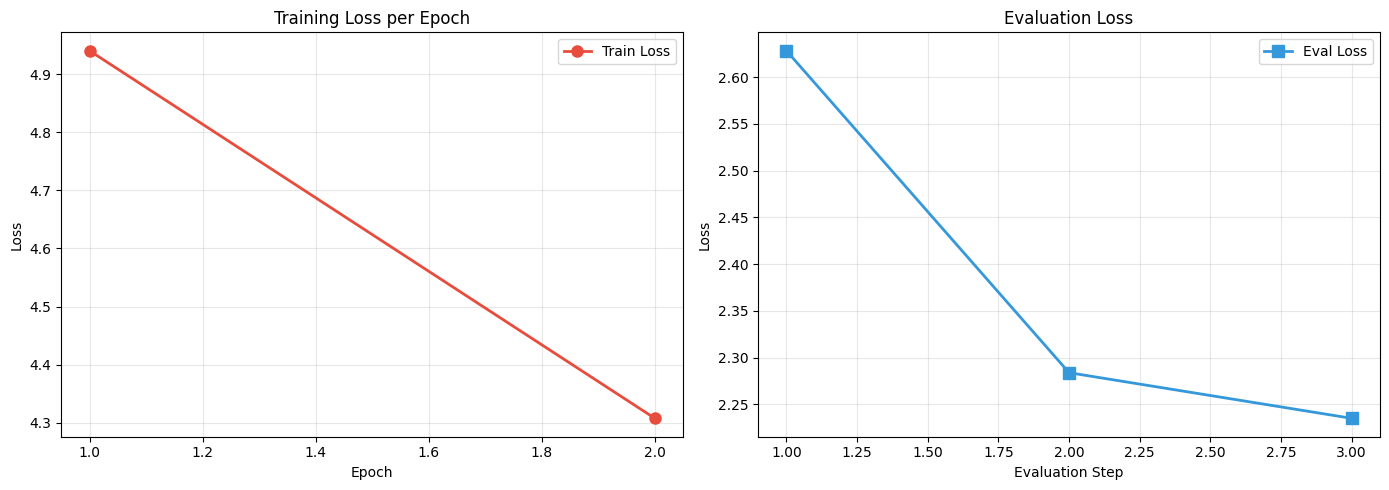


Loss reduction: 12.81%
Initial loss: 4.9406
Final loss: 4.3074


In [12]:
# Visualize training curves
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Training loss per epoch
epochs = range(1, len(train_history) + 1)
train_losses = [m['loss'] for m in train_history]

axes[0].plot(epochs, train_losses, marker='o', linewidth=2, markersize=8, 
             color='#e74c3c', label='Train Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training Loss per Epoch')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Evaluation loss over time
if eval_history:
    eval_steps = range(1, len(eval_history) + 1)
    eval_losses = [m['eval_loss'] for m in eval_history]
    
    axes[1].plot(eval_steps, eval_losses, marker='s', linewidth=2, markersize=8,
                 color='#3498db', label='Eval Loss')
    axes[1].set_xlabel('Evaluation Step')
    axes[1].set_ylabel('Loss')
    axes[1].set_title('Evaluation Loss')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print loss reduction
if len(train_losses) > 1:
    initial_loss = train_losses[0]
    final_loss = train_losses[-1]
    reduction = (initial_loss - final_loss) / initial_loss * 100
    print(f"\nLoss reduction: {reduction:.2f}%")
    print(f"Initial loss: {initial_loss:.4f}")
    print(f"Final loss: {final_loss:.4f}")

## 10. Test Model Generation After Training

In [13]:
# Test generation on validation samples
print("=" * 70)
print("TESTING GENERATION AFTER TRAINING")
print("=" * 70)

student.model.eval()

# Get a batch from validation set
val_batch = next(iter(val_loader))
val_batch = {k: v.to(device) for k, v in val_batch.items()}

# Generate predictions
with torch.no_grad():
    generated_ids = student.generate(
        input_ids=val_batch['input_ids'][:3],  # First 3 samples
        attention_mask=val_batch['attention_mask'][:3],
        max_length=64,
        num_beams=4
    )

# Decode
predictions = student.decode_batch(generated_ids)
inputs = student.decode_batch(val_batch['input_ids'][:3])

labels = val_batch['labels'][:3].clone()
labels[labels == -100] = student.tokenizer.pad_token_id
ground_truths = student.decode_batch(labels)

# Display
for i in range(3):
    print(f"\n{'='*70}")
    print(f"SAMPLE {i+1}")
    print(f"{'='*70}")
    print(f"\nInput:\n{inputs[i]}")
    print(f"\nGround Truth:\n{ground_truths[i]}")
    print(f"\nPrediction:\n{predictions[i]}")

TESTING GENERATION AFTER TRAINING

SAMPLE 1

Input:
nli premise: Two women are embracing while holding to go packages. hypothesis: The sisters are hugging goodbye while holding to go packages after just eating lunch.

Ground Truth:
neutral explanation: The to go packages may not be from lunch.

Prediction:
nli premise: Two women are embracing while holding to go packages. hypothesis: The sisters are hugging goodbye while holding to go packages after just eating lunch.

SAMPLE 2

Input:
nli premise: Two women are embracing while holding to go packages. hypothesis: Two woman are holding packages.

Ground Truth:
entailment explanation: Saying the two women are holding packages is a way to paraphrase that the packages they are holding are to go packages.

Prediction:
nli premise: Two women are embracing while holding to go packages.

SAMPLE 3

Input:
nli premise: Two women are embracing while holding to go packages. hypothesis: The men are fighting outside a deli.

Ground Truth:
contradict

## 11. Test Checkpoint Saving and Loading

In [14]:
# Check saved checkpoints
print("=" * 70)
print("CHECKING SAVED CHECKPOINTS")
print("=" * 70)

output_dir = Path(training_config.output_dir)

if output_dir.exists():
    checkpoints = list(output_dir.iterdir())
    print(f"\nFound {len(checkpoints)} items in output directory:")
    for checkpoint in sorted(checkpoints):
        if checkpoint.is_dir():
            size = sum(f.stat().st_size for f in checkpoint.rglob('*') if f.is_file())
            print(f"  📁 {checkpoint.name} ({size / 1e6:.2f} MB)")
        else:
            print(f"  📄 {checkpoint.name}")
else:
    print("\nOutput directory not found!")

CHECKING SAVED CHECKPOINTS

Found 4 items in output directory:
  📁 best_model (926.17 MB)
  📁 checkpoint-20 (926.17 MB)
  📁 final_model (926.17 MB)
  📄 training_config.json


In [15]:
# Test loading best model
print("\n" + "=" * 70)
print("TESTING MODEL LOADING")
print("=" * 70)

best_model_path = output_dir / "best_model"

if best_model_path.exists():
    print(f"\nLoading best model from {best_model_path}...")
    
    # Load model
    loaded_student = StudentModel.load_model(
        str(best_model_path),
        config=student_config
    )
    
    print("✓ Model loaded successfully!")
    print(f"✓ Parameters: {loaded_student.count_parameters():,}")
    
    # Test generation with loaded model
    loaded_student.model.eval()
    with torch.no_grad():
        test_gen = loaded_student.generate(
            input_ids=val_batch['input_ids'][:1],
            attention_mask=val_batch['attention_mask'][:1]
        )
    
    test_pred = loaded_student.decode_batch(test_gen)[0]
    print(f"\nTest generation: {test_pred[:100]}...")
    print("\n✓ Loaded model can generate!")
else:
    print("\nBest model not found (training might not have completed enough steps)")

INFO:src.models.student:Loading model from ../experiments/test_run/best_model
INFO:src.models.student:Initializing student model: ../experiments/test_run/best_model



TESTING MODEL LOADING

Loading best model from ../experiments/test_run/best_model...


INFO:src.models.student:Model loaded successfully on cuda
INFO:src.models.student:Model parameters: 76,961,152
`generation_config` default values have been modified to match model-specific defaults: {'decoder_start_token_id': 0}. If this is not desired, please set these values explicitly.


✓ Model loaded successfully!
✓ Parameters: 76,961,152

Test generation: nli premise: Two women are embracing while holding to go packages. hypothesis: The sisters are huggi...

✓ Loaded model can generate!


## 12. Test Resume Training

In [16]:
# Test resuming from checkpoint
print("=" * 70)
print("TESTING RESUME TRAINING")
print("=" * 70)

# Find a checkpoint to resume from
checkpoints = sorted(
    [d for d in output_dir.iterdir() 
     if d.is_dir() and d.name.startswith("checkpoint-")],
    key=lambda x: int(x.name.split("-")[1])
)

if checkpoints:
    resume_checkpoint = checkpoints[-1]
    print(f"\nResuming from: {resume_checkpoint.name}")
    
    # Create new trainer and load checkpoint
    resume_config = TrainingConfig(
        num_epochs=3,  # Train 1 more epoch
        learning_rate=5e-5,
        warmup_steps=10,
        eval_steps=10,
        save_steps=20,
        logging_steps=5,
        output_dir="../experiments/test_run_resumed",
        eval_strategy="steps"
    )
    
    # Load model from checkpoint
    resumed_student = StudentModel.load_model(
        str(resume_checkpoint),
        config=student_config
    )
    
    resumed_trainer = Trainer(
        model=resumed_student,
        train_dataloader=train_loader,
        eval_dataloader=val_loader,
        distillation_strategy=distillation_strategy,
        config=resume_config
    )
    
    # Load training state
    resumed_trainer.load_checkpoint(str(resume_checkpoint))
    
    print(f"\n✓ Checkpoint loaded!")
    print(f"  Resumed from step: {resumed_trainer.global_step}")
    print(f"  Resumed from epoch: {resumed_trainer.epoch}")
    print(f"  Best metric: {resumed_trainer.best_metric:.4f}")
    
    print("\n💡 Training state successfully restored!")
    print("   You can call resumed_trainer.train() to continue training.")
else:
    print("\nNo checkpoints found to resume from")

INFO:src.models.student:Loading model from ../experiments/test_run/checkpoint-20
INFO:src.models.student:Initializing student model: ../experiments/test_run/checkpoint-20


TESTING RESUME TRAINING

Resuming from: checkpoint-20


INFO:src.models.student:Model loaded successfully on cuda
INFO:src.models.student:Model parameters: 76,961,152
INFO:src.training.trainer:Training config saved to ../experiments/test_run_resumed/training_config.json
INFO:src.training.trainer:Trainer initialized
INFO:src.training.trainer:Output directory: ../experiments/test_run_resumed
INFO:src.training.trainer:Total training steps: 39
INFO:src.training.trainer:Loading checkpoint from ../experiments/test_run/checkpoint-20
INFO:src.training.trainer:Resumed from step 20, epoch 1



✓ Checkpoint loaded!
  Resumed from step: 20
  Resumed from epoch: 1
  Best metric: 2.2839

💡 Training state successfully restored!
   You can call resumed_trainer.train() to continue training.


## 13. Analyze Optimizer State

In [17]:
# Analyze optimizer state
print("=" * 70)
print("OPTIMIZER STATE ANALYSIS")
print("=" * 70)

optimizer_state = trainer.optimizer.state_dict()

print(f"\nOptimizer: {type(trainer.optimizer).__name__}")
print(f"\nParameter groups: {len(optimizer_state['param_groups'])}")

for i, group in enumerate(optimizer_state['param_groups']):
    print(f"\nGroup {i}:")
    print(f"  Learning rate: {group['lr']:.2e}")
    print(f"  Weight decay: {group['weight_decay']}")
    print(f"  Parameters: {len(group['params'])}")

# Check learning rate schedule
if trainer.scheduler:
    current_lr = trainer.optimizer.param_groups[0]['lr']
    print(f"\nCurrent learning rate: {current_lr:.2e}")
    print(f"Initial learning rate: {training_config.learning_rate:.2e}")
    print(f"LR change: {(current_lr / training_config.learning_rate - 1) * 100:+.1f}%")

OPTIMIZER STATE ANALYSIS

Optimizer: AdamW

Parameter groups: 2

Group 0:
  Learning rate: 0.00e+00
  Weight decay: 0.01
  Parameters: 146

Group 1:
  Learning rate: 0.00e+00
  Weight decay: 0.0
  Parameters: 44

Current learning rate: 0.00e+00
Initial learning rate: 5.00e-05
LR change: -100.0%


## 14. Compare Before/After Training Performance

BEFORE/AFTER COMPARISON

Evaluation Loss:
  Initial: 2.6282
  Final: 2.2351
  Improvement: 0.3931 (14.96%)


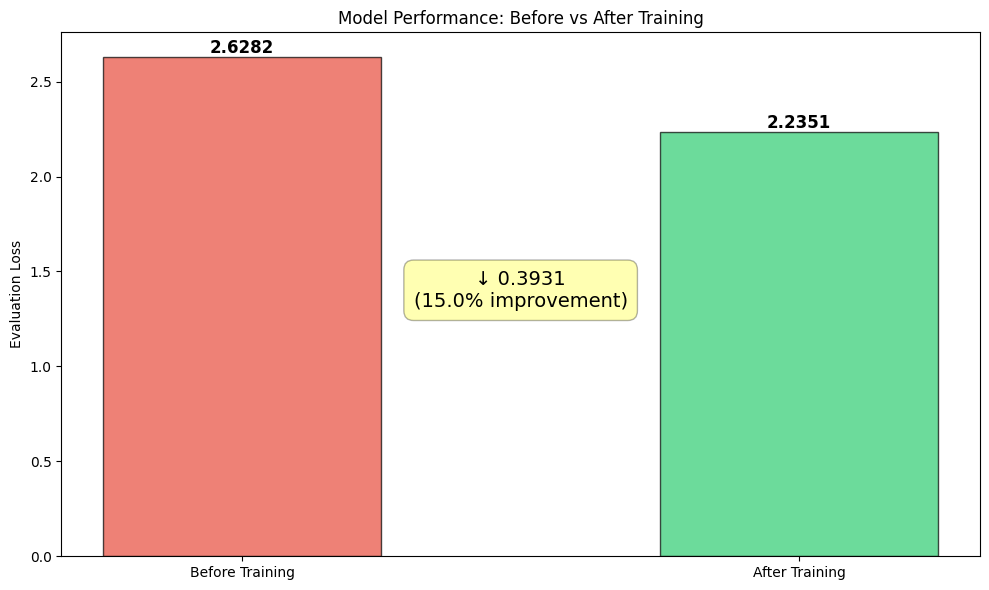

In [18]:
# Compare loss before and after training
print("=" * 70)
print("BEFORE/AFTER COMPARISON")
print("=" * 70)

if eval_history:
    initial_eval_loss = eval_history[0]['eval_loss']
    final_eval_loss = eval_history[-1]['eval_loss']
    
    print(f"\nEvaluation Loss:")
    print(f"  Initial: {initial_eval_loss:.4f}")
    print(f"  Final: {final_eval_loss:.4f}")
    print(f"  Improvement: {initial_eval_loss - final_eval_loss:.4f} ({(initial_eval_loss - final_eval_loss) / initial_eval_loss * 100:.2f}%)")
    
    # Visualize improvement
    fig, ax = plt.subplots(figsize=(10, 6))
    
    losses = [initial_eval_loss, final_eval_loss]
    labels = ['Before Training', 'After Training']
    colors = ['#e74c3c', '#2ecc71']
    
    bars = ax.bar(labels, losses, color=colors, alpha=0.7, edgecolor='black', width=0.5)
    ax.set_ylabel('Evaluation Loss')
    ax.set_title('Model Performance: Before vs After Training')
    
    # Add value labels
    for bar, loss in zip(bars, losses):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{loss:.4f}',
                ha='center', va='bottom', fontsize=12, fontweight='bold')
    
    # Add improvement annotation
    improvement = initial_eval_loss - final_eval_loss
    ax.annotate(
        f'↓ {improvement:.4f}\n({improvement/initial_eval_loss*100:.1f}% improvement)',
        xy=(0.5, max(losses) * 0.5),
        fontsize=14,
        ha='center',
        bbox=dict(boxstyle='round,pad=0.5', facecolor='yellow', alpha=0.3)
    )
    
    plt.tight_layout()
    plt.show()
else:
    print("\nNo evaluation history available for comparison")

## 15. Test Different Training Configurations

INFO:src.training.distillation:Initialized DistillationLoss with config:
INFO:src.training.distillation:  CE weight: 1.0
INFO:src.training.distillation:  Distill weight: 0.0
INFO:src.training.distillation:  Temperature: 2.0
INFO:src.training.distillation:  Type: sequence_level
INFO:src.training.distillation:Initialized SequenceLevelDistillation
INFO:src.training.distillation:Initialized DistillationLoss with config:
INFO:src.training.distillation:  CE weight: 1.0
INFO:src.training.distillation:  Distill weight: 0.0
INFO:src.training.distillation:  Temperature: 2.0
INFO:src.training.distillation:  Type: sequence_level
INFO:src.training.distillation:Initialized SequenceLevelDistillation
INFO:src.training.distillation:Initialized DistillationLoss with config:
INFO:src.training.distillation:  CE weight: 1.0
INFO:src.training.distillation:  Distill weight: 0.0
INFO:src.training.distillation:  Temperature: 2.0
INFO:src.training.distillation:  Type: sequence_level
INFO:src.training.distillati

TESTING LABEL SMOOTHING IMPACT

Label Smoothing Impact on Loss:
  Smoothing=0.0: loss=2.4287
  Smoothing=0.1: loss=4.0154
  Smoothing=0.2: loss=5.6021


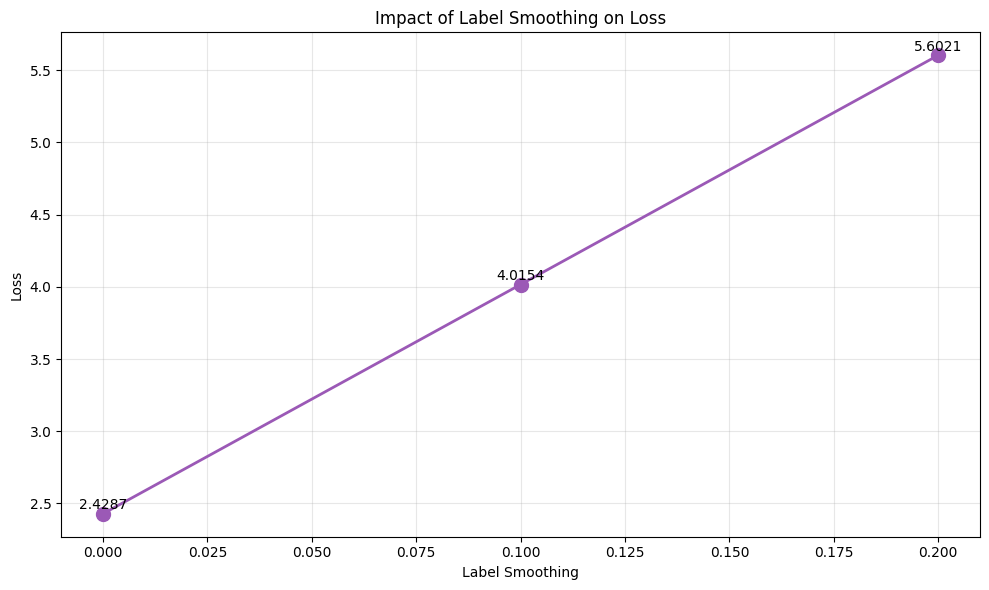

In [19]:
# Compare different label smoothing values
print("=" * 70)
print("TESTING LABEL SMOOTHING IMPACT")
print("=" * 70)

smoothing_values = [0.0, 0.1, 0.2]
smoothing_results = []

# Get a test batch
test_batch = next(iter(train_loader))
test_batch = {k: v.to(device) for k, v in test_batch.items()}

for smoothing in smoothing_values:
    # Create distillation with different smoothing
    test_config = DistillationConfig(
        ce_weight=1.0,
        label_smoothing=smoothing
    )
    test_strategy = SequenceLevelDistillation(test_config)
    
    # Compute loss
    student.model.eval()
    with torch.no_grad():
        outputs = student(
            input_ids=test_batch['input_ids'],
            attention_mask=test_batch['attention_mask'],
            labels=test_batch['labels']
        )
        losses = test_strategy.compute_loss(outputs['logits'], test_batch['labels'])
    
    smoothing_results.append({
        'smoothing': smoothing,
        'loss': losses['total_loss'].item()
    })

# Display results
print("\nLabel Smoothing Impact on Loss:")
for result in smoothing_results:
    print(f"  Smoothing={result['smoothing']:.1f}: loss={result['loss']:.4f}")

# Visualize
fig, ax = plt.subplots(figsize=(10, 6))
smoothing_vals = [r['smoothing'] for r in smoothing_results]
loss_vals = [r['loss'] for r in smoothing_results]

ax.plot(smoothing_vals, loss_vals, marker='o', linewidth=2, markersize=10, color='#9b59b6')
ax.set_xlabel('Label Smoothing')
ax.set_ylabel('Loss')
ax.set_title('Impact of Label Smoothing on Loss')
ax.grid(True, alpha=0.3)

for x, y in zip(smoothing_vals, loss_vals):
    ax.text(x, y + 0.01, f'{y:.4f}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

## 16. Memory and Speed Profiling

In [ ]:
# Profile training step memory and speed
print("=" * 70)
print("PROFILING TRAINING STEP")
print("=" * 70)

student.model.train()

if device == "cuda":
    torch.cuda.empty_cache()
    torch.cuda.reset_peak_memory_stats()
    
    initial_memory = torch.cuda.memory_allocated() / 1e6

# Time training step
times = []
for _ in range(5):
    batch = next(iter(train_loader))
    batch = {k: v.to(device) for k, v in batch.items()}
    
    start = time.time()
    
    # Forward
    outputs = student(
        input_ids=batch['input_ids'],
        attention_mask=batch['attention_mask'],
        labels=batch['labels']
    )
    losses = distillation_strategy.compute_loss(outputs['logits'], batch['labels'])
    loss = losses['total_loss']
    
    # Backward
    loss.backward()
    
    # Optimizer step
    trainer.optimizer.step()
    trainer.optimizer.zero_grad()
    
    if device == "cuda":
        torch.cuda.synchronize()
    
    times.append(time.time() - start)

avg_time = np.mean(times[1:])  # Skip first (warmup)
std_time = np.std(times[1:])

print(f"\nTraining Step Performance:")
print(f"  Average time: {avg_time:.3f}s ± {std_time:.3f}s")
print(f"  Throughput: {len(batch['input_ids']) / avg_time:.2f} samples/sec")

if device == "cuda":
    peak_memory = torch.cuda.max_memory_allocated() / 1e6
    print(f"\nMemory Usage:")
    print(f"  Initial: {initial_memory:.2f} MB")
    print(f"  Peak: {peak_memory:.2f} MB")
    print(f"  Overhead: {peak_memory - initial_memory:.2f} MB")

## 17. Summary and Recommendations

In [ ]:
print("\n" + "=" * 70)
print("TRAINING LOOP TESTING SUMMARY")
print("=" * 70)

print("\n✅ COMPONENTS TESTED:")
print("  ✓ Distillation loss computation")
print("  ✓ Single training step (forward + backward)")
print("  ✓ Trainer initialization")
print("  ✓ Full training loop (2 epochs)")
print("  ✓ Evaluation pipeline")
print("  ✓ Checkpointing (save/load)")
print("  ✓ Resume training")
print("  ✓ Optimizer state management")
print("  ✓ Learning rate scheduling")

print("\n📊 TRAINING RESULTS:")
print(f"  • Training completed: {training_config.num_epochs} epochs")
print(f"  • Total steps: {trainer.global_step}")
print(f"  • Final train loss: {train_history[-1]['loss']:.4f}")
if eval_history:
    print(f"  • Final eval loss: {eval_history[-1]['eval_loss']:.4f}")
    improvement = (eval_history[0]['eval_loss'] - eval_history[-1]['eval_loss']) / eval_history[0]['eval_loss'] * 100
    print(f"  • Eval improvement: {improvement:.2f}%")
print(f"  • Training time: {training_time:.2f}s")
print(f"  • Checkpoints saved: {len([d for d in output_dir.iterdir() if d.is_dir()])}")

print("\n⚡ PERFORMANCE:")
print(f"  • Avg step time: {avg_time:.3f}s")
print(f"  • Throughput: {len(batch['input_ids']) / avg_time:.2f} samples/sec")
if device == "cuda":
    print(f"  • Peak GPU memory: {peak_memory:.2f} MB")

print("\n" + "=" * 70)
print("🎉 ALL TRAINING LOOP TESTS PASSED!")
print("=" * 70)